In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,  classification_report
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
import numpy as np
import re

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    
    # Remove usernames and URLs
    text = re.sub(r'^@\S+\s*', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    text = text.lower()
        
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def load_and_prepare_data():
    
    balanced_soft_vote = pd.read_csv('balanced_soft_vote.csv')
    nohate_balance = pd.read_csv('nohate_balance.csv')
    hate_balance = pd.read_csv('hate_balance.csv')
    
    balanced_soft_vote = balanced_soft_vote[['text', 'label']]

    # Split the balanced dataset into 'no_hate' and 'hate' labels
    no_hate = balanced_soft_vote[balanced_soft_vote['label'] == 0]
    hate = balanced_soft_vote[balanced_soft_vote['label'] == 1]

    # Randomly sample 1200 rows from 'no_hate' to replace
    no_hate_to_replace = no_hate.sample(n=1200, random_state=42)
    no_hate_remaining = no_hate.drop(no_hate_to_replace.index)

    # Concatenate the datasets 
    final_dataset = pd.concat([no_hate_remaining, nohate_balance, hate, hate_balance], ignore_index=True)

    final_dataset = final_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    final_dataset['text'] = final_dataset['text'].apply(clean_text)

    print(f"Final dataset shape: {final_dataset.shape}")
    print(final_dataset['label'].value_counts())

    return final_dataset

df = load_and_prepare_data()

# data split
train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df["label"])
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, random_state=42, stratify=train_val_df["label"])

print(f"Train set size: {train_df.shape[0]}")
print(f"Validation set size: {val_df.shape[0]}")
print(f"Test set size: {test_df.shape[0]}")


Using device: cuda
Final dataset shape: (30189, 3)
label
1    15114
0    15075
Name: count, dtype: int64
Train set size: 21131
Validation set size: 4529
Test set size: 4529


In [ ]:
#  Load tokenizer and base model
MODEL_PATH = "./dziri_binary_final"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=2)

# Prepare model for LoRA
base_model = prepare_model_for_kbit_training(base_model)

# LoRA config
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value", "key", "dense"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(base_model, lora_config)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

In [ ]:
train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
test_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

for dataset in [train_dataset, val_dataset, test_dataset]:
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

#  Metrics

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    report = classification_report(labels, preds, output_dict=True)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": report["weighted avg"]["f1-score"],
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"]
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./dziri_lora_softvote",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    num_train_epochs=6,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available()
)

Map:   0%|          | 0/21131 [00:00<?, ? examples/s]

Map:   0%|          | 0/4529 [00:00<?, ? examples/s]

Map:   0%|          | 0/4529 [00:00<?, ? examples/s]

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("Starting training...")
trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting training...


TrainOutput(global_step=1000, training_loss=0.30705875205993655, metrics={'train_runtime': 361.5692, 'train_samples_per_second': 350.655, 'train_steps_per_second': 10.969, 'total_flos': 2136440179000320.0, 'train_loss': 0.30705875205993655, 'epoch': 1.5128593040847202})

In [ ]:
# Save final LoRA model
model.save_pretrained("./dziri_lora_2")
tokenizer.save_pretrained("./dziri_lora_2")
print("\n✅ Model trained and saved!")


✅ Model trained and saved!


In [ ]:
print("\nFinal Test Evaluation Results:")
test_results = trainer.evaluate(test_dataset)
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")


Final Test Evaluation Results:


eval_loss: 0.1836
eval_accuracy: 0.9329
eval_f1: 0.9329
eval_precision: 0.9332
eval_recall: 0.9329
eval_runtime: 15.1165
eval_samples_per_second: 299.6060
eval_steps_per_second: 9.3940
epoch: 1.5129


Map:   0%|          | 0/4529 [00:00<?, ? examples/s]

<Figure size 600x600 with 0 Axes>

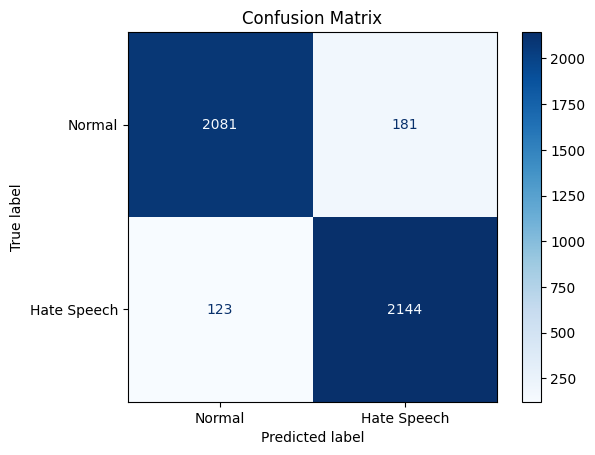

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_dataset = Dataset.from_pandas(test_df)
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

predictions_output = trainer.predict(test_dataset)
preds = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Hate Speech"])

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Inference
def predict_hate_speech(texts):
    encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**encodings)
    predictions = torch.argmax(outputs.logits, dim=1)
    return predictions.cpu().numpy()

example_texts = [
    "انا اكره الظلم و التمييز",
    "نكره العدس و اللوبيا",
    "اكره التركيين",
    "النساء رخيسات",
    "كل فتاة جامعية رخيسة",
    "البضاعة رخيسة",
    "في هذا السوق البضائع رخيسة"
    "السلع هنا رخيسة الثمن"
]

predictions = predict_hate_speech(example_texts)

print("\nExample Predictions:")
for text, pred in zip(example_texts, predictions):
    print(f"Text: {text} ---→ Prediction: {'🚨 HATE SPEECH' if pred == 1 else '✅ Normal'}")


Example Predictions:
Text: انا اكره الظلم و التمييز ---→ Prediction: ✅ Normal
Text: نكره العدس و اللوبيا ---→ Prediction: ✅ Normal
Text: اكره التركيين ---→ Prediction: 🚨 HATE SPEECH
Text: النساء رخيسات ---→ Prediction: 🚨 HATE SPEECH
Text: كل فتاة جامعية رخيسة ---→ Prediction: 🚨 HATE SPEECH
Text: البضاعة رخيسة ---→ Prediction: 🚨 HATE SPEECH
Text: في هذا السوق البضائع رخيسة ---→ Prediction: ✅ Normal
Text: السلع هنا رخيسة الثمن ---→ Prediction: ✅ Normal
